# Penjelasan Model

Model ini merupakan model **klasifikasi multi-output** yang bertujuan untuk memprediksi kondisi mental seseorang—meliputi **stres**, **kecemasan (anxiety)**, dan **depresi (depression)** berdasarkan data hasil asesmen psikologis serta data demografis pengguna. Model ini dirancang menggunakan **kerangka kerja TensorFlow**, yang mendukung arsitektur jaringan saraf (neural network) untuk klasifikasi kompleks dengan lebih dari satu output target.

# Perkenalan Dataset

Dataset yang digunakan dalam analisis ini adalah **[University Students Mental Health](https://www.kaggle.com/datasets/mohsenzergani/bangladeshi-university-students-mental-health?resource=download)**, yang berisi informasi terkait kesehatan mental mahasiswa. Data ini digunakan untuk memahami tingkat stress, anxiety, dan depression pada mahasiswa serta keterkaitannya dengan faktor sosiodeomografis.

# Import Library

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical



# Data Loading

In [2]:
# Load dataset
df = pd.read_csv('/content/mental_health_data.csv')
df.head()

,1. Age,2. Gender,3. University,4. Department,5. Academic Year,6. Current CGPA,7. Did you receive a waiver or scholarship at your university?,"1. In a semester, how often you felt nervous, anxious or on edge due to academic pressure?","2. In a semester, how often have you been unable to stop worrying about your academic affairs?","3. In a semester, how often have you had trouble relaxing due to academic pressure?",...,"2. In a semester, how often have you been feeling down, depressed or hopeless?","3. In a semester, how often have you had trouble falling or staying asleep, or sleeping too much?","4. In a semester, how often have you been feeling tired or having little energy?","5. In a semester, how often have you had poor appetite or overeating?","6. In a semester, how often have you been feeling bad about yourself - or that you are a failure or have let yourself or your family down?","7. In a semester, how often have you been having trouble concentrating on things, such as reading the books or watching television?","8. In a semester, how often have you moved or spoke too slowly for other people to notice? Or you've been moving a lot more than usual because you've been restless?","9. In a semester, how often have you had thoughts that you would be better off dead, or of hurting yourself?",Depression Value,Depression Label
0,18-22,Female,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,Fourth Year or Equivalent,2.50 - 2.99,No,1,1,1,...,2,1,1,2,1,1,1,1,11,Moderate Depression
1,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.80 - 4.00,No,2,2,1,...,1,1,1,1,1,1,1,1,9,Mild Depression
2,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.00 - 3.39,No,2,1,1,...,0,2,3,2,2,2,2,1,16,Moderately Severe Depression
3,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.40 - 3.79,No,2,1,1,...,1,1,1,1,1,1,1,1,9,Mild Depression
4,18-22,Male,"Independent University, Bangladesh (IUB)",Engineering - CS / CSE / CSC / Similar to CS,First Year or Equivalent,3.40 - 3.79,No,1,1,1,...,1,1,1,1,1,1,1,1,9,Mild Depression


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 39 columns):
 #   Column                                                                                                                                                                 Non-Null Count  Dtype 
---  ------                                                                                                                                                                 --------------  ----- 
 0   1. Age                                                                                                                                                                 1977 non-null   object
 1   2. Gender                                                                                                                                                              1977 non-null   object
 2   3. University                                                                                               

## Data Cleaning

In [4]:
# Bersihkan nama kolom
def clean_column(col):
    col = re.sub(r'^\d+\.\s*', '', col)
    col = re.sub(r'^"\d+\.\s*', '', col)
    col = col.replace('"', '')
    col = col.strip()
    return col

df.columns = [clean_column(col) for col in df.columns]

In [5]:
# Rename kolom
df = df.rename(columns={
    "Age": "age",
    "Gender": "gender",
    "University": "university",
    "Department": "department",
    "Academic Year": "academic_year",
    "Current CGPA": "cgpa",
    "Did you receive a waiver or scholarship at your university?": "got_scholarship",

    # Anxiety Questions
    "In a semester, how often you felt nervous, anxious or on edge due to academic pressure?": "anxiety_q1",
    "In a semester, how often have you been unable to stop worrying about your academic affairs?": "anxiety_q2",
    "In a semester, how often have you had trouble relaxing due to academic pressure?": "anxiety_q3",
    "In a semester, how often have you been easily annoyed or irritated because of academic pressure?": "anxiety_q4",
    "In a semester, how often have you worried too much about academic affairs?": "anxiety_q5",
    "In a semester, how often have you been so restless due to academic pressure that it is hard to sit still?": "anxiety_q6",
    "In a semester, how often have you felt afraid, as if something awful might happen?": "anxiety_q7",
    "Anxiety Value": "anxiety_value",
    "Anxiety Label": "anxiety_label",

    # Stress Questions
    "In a semester, how often have you felt upset due to something that happened in your academic affairs?": "stress_q1",
    "In a semester, how often you felt as if you were unable to control important things in your academic affairs?": "stress_q2",
    "In a semester, how often you felt nervous and stressed because of academic pressure?": "stress_q3",
    "In a semester, how often you felt as if you could not cope with all the mandatory academic activities? (e.g, assignments, quiz, exams)": "stress_q4",
    "In a semester, how often you felt confident about your ability to handle your academic / university problems?": "stress_q5",
    "In a semester, how often you felt as if things in your academic life is going on your way?": "stress_q6",
    "In a semester, how often are you able to control irritations in your academic / university affairs?": "stress_q7",
    "In a semester, how often you felt as if your academic performance was on top?": "stress_q8",
    "In a semester, how often you got angered due to bad performance or low grades that is beyond your control?": "stress_q9",
    "In a semester, how often you felt as if academic difficulties are piling up so high that you could not overcome them?": "stress_q10",
    "Stress Value": "stress_value",
    "Stress Label": "stress_label",

    # Depression Questions
    "In a semester, how often have you had little interest or pleasure in doing things?": "depression_q1",
    "In a semester, how often have you been feeling down, depressed or hopeless?": "depression_q2",
    "In a semester, how often have you had trouble falling or staying asleep, or sleeping too much?": "depression_q3",
    "In a semester, how often have you been feeling tired or having little energy?": "depression_q4",
    "In a semester, how often have you had poor appetite or overeating?": "depression_q5",
    "In a semester, how often have you been feeling bad about yourself - or that you are a failure or have let yourself or your family down?": "depression_q6",
    "In a semester, how often have you been having trouble concentrating on things, such as reading the books or watching television?": "depression_q7",
    "In a semester, how often have you moved or spoke too slowly for other people to notice? Or you've been moving a lot more than usual because you've been restless?": "depression_q8",
    "In a semester, how often have you had thoughts that you would be better off dead, or of hurting yourself?": "depression_q9",
    "Depression Value": "depression_value",
    "Depression Label": "depression_label"
})

In [6]:
# Hapus kolom yang tidak diperlukan
df = df.drop(['depression_value', 'anxiety_value', 'stress_value', 'university', 'department'], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               1977 non-null   object
 1   gender            1977 non-null   object
 2   academic_year     1977 non-null   object
 3   cgpa              1977 non-null   object
 4   got_scholarship   1977 non-null   object
 5   anxiety_q1        1977 non-null   int64 
 6   anxiety_q2        1977 non-null   int64 
 7   anxiety_q3        1977 non-null   int64 
 8   anxiety_q4        1977 non-null   int64 
 9   anxiety_q5        1977 non-null   int64 
 10  anxiety_q6        1977 non-null   int64 
 11  anxiety_q7        1977 non-null   int64 
 12  anxiety_label     1977 non-null   object
 13  stress_q1         1977 non-null   int64 
 14  stress_q2         1977 non-null   int64 
 15  stress_q3         1977 non-null   int64 
 16  stress_q4         1977 non-null   int64 
 17  stress_q5     

Berikut adalah penjelasan singkat untuk masing-masing kolom dalam data:

1. **age**: Umur responden.
2. **gender**: Jenis kelamin responden.
3. **academic\_year**: Tahun akademik yang diikuti oleh responden.
4. **cgpa**: IPK (Cumulative Grade Point Average) responden, yang menunjukkan kinerja akademik mereka.
5. **got\_scholarship**: Menunjukkan apakah responden mendapatkan beasiswa atau tidak.
6. **anxiety\_q1 - anxiety\_q7**: Nilai untuk tujuh pertanyaan terkait kecemasan responden.
7. **anxiety\_label**: Label yang menunjukkan tingkat kecemasan responden (misalnya, severe anxiety, moderate anxiety, mild anxiety, minimal anxiety).
8. **stress\_q1 - stress\_q10**: Nilai untuk sepuluh pertanyaan terkait stres responden.
9. **stress\_label**: Label yang menunjukkan tingkat stres responden (misalnya, moderate stress, high perceived stress, low stress).
10. **depression\_q1 - depression\_q9**: Nilai untuk sembilan pertanyaan terkait depresi responden.
11. **depression\_label**: Label yang menunjukkan tingkat depresi responden (misalnya, moderately severe depression, severe depression, moderate depression, mild depression, minimal depression, no depression).



In [8]:
# Cek missing value
print("\nMissing values per fitur:")
print(df.isnull().sum())


Missing values per fitur:
age                 0
gender              0
academic_year       0
cgpa                0
got_scholarship     0
anxiety_q1          0
anxiety_q2          0
anxiety_q3          0
anxiety_q4          0
anxiety_q5          0
anxiety_q6          0
anxiety_q7          0
anxiety_label       0
stress_q1           0
stress_q2           0
stress_q3           0
stress_q4           0
stress_q5           0
stress_q6           0
stress_q7           0
stress_q8           0
stress_q9           0
stress_q10          0
stress_label        0
depression_q1       0
depression_q2       0
depression_q3       0
depression_q4       0
depression_q5       0
depression_q6       0
depression_q7       0
depression_q8       0
depression_q9       0
depression_label    0
dtype: int64


Tidak terdapat missing value pada dataframe tersebut.

In [9]:
# cek data duplikat
duplicates = df.duplicated()

print("Baris duplikat: ")
print(df[duplicates])

Baris duplikat: 
        age gender              academic_year         cgpa got_scholarship  \
1304  18-22   Male   First Year or Equivalent  3.40 - 3.79              No   
1342  18-22   Male   First Year or Equivalent  3.40 - 3.79             Yes   
1363  18-22   Male   Third Year or Equivalent  3.00 - 3.39              No   
1438  23-26   Male   Third Year or Equivalent  3.00 - 3.39              No   
1908  23-26   Male  Fourth Year or Equivalent  3.00 - 3.39              No   

      anxiety_q1  anxiety_q2  anxiety_q3  anxiety_q4  anxiety_q5  ...  \
1304           1           1           1           1           1  ...   
1342           1           1           1           1           1  ...   
1363           1           1           1           1           1  ...   
1438           0           0           0           0           0  ...   
1908           1           1           1           1           1  ...   

      depression_q1  depression_q2 depression_q3  depression_q4  \
1304    

In [10]:
# Hapus semua baris duplikat
df_cleaned = df.drop_duplicates()

# Cek kembali baris duplikat
duplicates = df_cleaned.duplicated()

print("Baris setelah hapus duplikat: ")
print(df_cleaned[duplicates])

Baris setelah hapus duplikat: 
Empty DataFrame
Columns: [age, gender, academic_year, cgpa, got_scholarship, anxiety_q1, anxiety_q2, anxiety_q3, anxiety_q4, anxiety_q5, anxiety_q6, anxiety_q7, anxiety_label, stress_q1, stress_q2, stress_q3, stress_q4, stress_q5, stress_q6, stress_q7, stress_q8, stress_q9, stress_q10, stress_label, depression_q1, depression_q2, depression_q3, depression_q4, depression_q5, depression_q6, depression_q7, depression_q8, depression_q9, depression_label]
Index: []

[0 rows x 34 columns]


# EDA

In [11]:
# Tinjau jumlah baris dan kolom dalam dataset
df_cleaned.shape

(1972, 34)

Data tersebut memiliki 1972 baris dan 34 kolom

In [12]:
# Lihat persebaran label
print("Stress Label Distribution:")
print(df_cleaned['stress_label'].value_counts())
print("\n")

print("Anxiety Label Distribution:")
print(df_cleaned['anxiety_label'].value_counts())
print("\n")

print("Depression Label Distribution:")
print(df_cleaned['depression_label'].value_counts())


Stress Label Distribution:
stress_label
Moderate Stress          1311
High Perceived Stress     546
Low Stress                115
Name: count, dtype: int64


Anxiety Label Distribution:
anxiety_label
Severe Anxiety      714
Moderate Anxiety    610
Mild Anxiety        491
Minimal Anxiety     157
Name: count, dtype: int64


Depression Label Distribution:
depression_label
Moderately Severe Depression    495
Severe Depression               488
Moderate Depression             449
Mild Depression                 404
Minimal Depression               93
No Depression                    43
Name: count, dtype: int64


<ipython-input-13-8d2c5fa96797>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stress_label', data=df_cleaned, order=df_cleaned['stress_label'].value_counts().index, ax=axs[0], palette='Reds')
<ipython-input-13-8d2c5fa96797>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='anxiety_label', data=df_cleaned, order=df_cleaned['anxiety_label'].value_counts().index, ax=axs[1], palette='Blues')
<ipython-input-13-8d2c5fa96797>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='depression_label', data=df_cleaned, order=df_cleaned['de

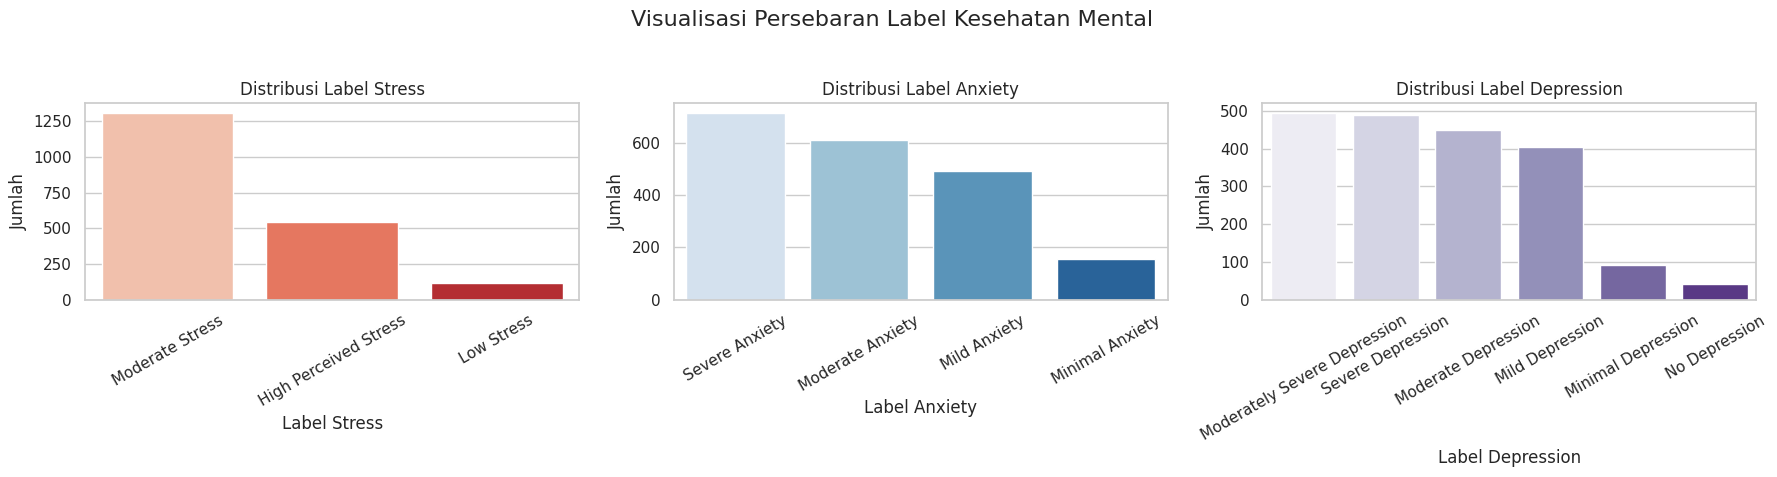

In [13]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Stress label plot
sns.countplot(x='stress_label', data=df_cleaned, order=df_cleaned['stress_label'].value_counts().index, ax=axs[0], palette='Reds')
axs[0].set_title('Distribusi Label Stress')
axs[0].set_xlabel('Label Stress')
axs[0].set_ylabel('Jumlah')
axs[0].tick_params(axis='x', rotation=30)

# Anxiety label plot
sns.countplot(x='anxiety_label', data=df_cleaned, order=df_cleaned['anxiety_label'].value_counts().index, ax=axs[1], palette='Blues')
axs[1].set_title('Distribusi Label Anxiety')
axs[1].set_xlabel('Label Anxiety')
axs[1].set_ylabel('Jumlah')
axs[1].tick_params(axis='x', rotation=30)

# Depression label plot
sns.countplot(x='depression_label', data=df_cleaned, order=df_cleaned['depression_label'].value_counts().index, ax=axs[2], palette='Purples')
axs[2].set_title('Distribusi Label Depression')
axs[2].set_xlabel('Label Depression')
axs[2].set_ylabel('Jumlah')
axs[2].tick_params(axis='x', rotation=30)

plt.suptitle('Visualisasi Persebaran Label Kesehatan Mental', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Distribusi Karakteristik Demografis

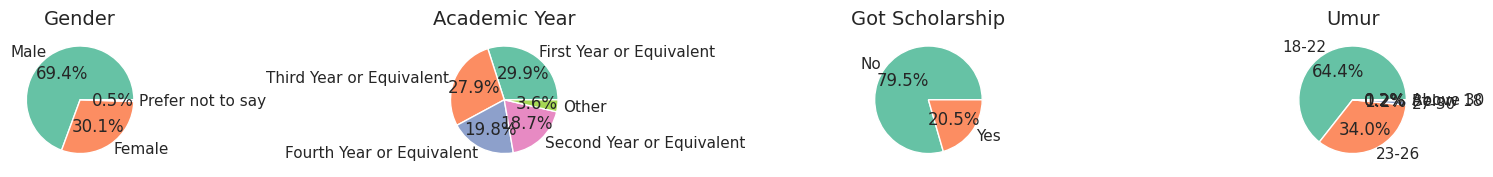

In [14]:
palette = sns.color_palette("Set2")
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Pie chart Gender
axs[0].pie(
    df["gender"].value_counts(),
    labels=df["gender"].value_counts().index,
    autopct='%1.1f%%',
    colors=palette
)
axs[0].set_title("Gender", fontsize=14)

# Pie chart Academic Year
axs[1].pie(
    df["academic_year"].value_counts(),
    labels=df["academic_year"].value_counts().index,
    autopct='%1.1f%%',
    colors=palette
)
axs[1].set_title("Academic Year", fontsize=14)

# Pie chart Got Scholarship
axs[2].pie(
    df["got_scholarship"].value_counts(),
    labels=df["got_scholarship"].value_counts().index,
    autopct='%1.1f%%',
    colors=palette
)
axs[2].set_title("Got Scholarship", fontsize=14)

# Pie chart Got Scholarship
axs[3].pie(
    df["age"].value_counts(),
    labels=df["age"].value_counts().index,
    autopct='%1.1f%%',
    colors=palette
)
axs[3].set_title("Umur", fontsize=14)

plt.tight_layout()
plt.show()


**Insight**
1. **Gender**: Mayoritas responden adalah laki-laki (69,4%), sementara perempuan hanya 30,1%.  
2. **Tahun Akademik**: Responden terbanyak berasal dari tahun pertama (29,9%) dan tahun ketiga, dengan partisipasi tahun keempat paling rendah (3,6%).  
3. **Penerima Beasiswa"**: Sebagian besar responden (79,5%) tidak mendapatkan beasiswa.

###  Apakah terdapat perbedaan rata-rata skor pertanyaan stres berdasarkan gender?

<ipython-input-15-4879e875b685>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_stress_by_gender, x='gender', y='total_stress_score', palette='Set2')


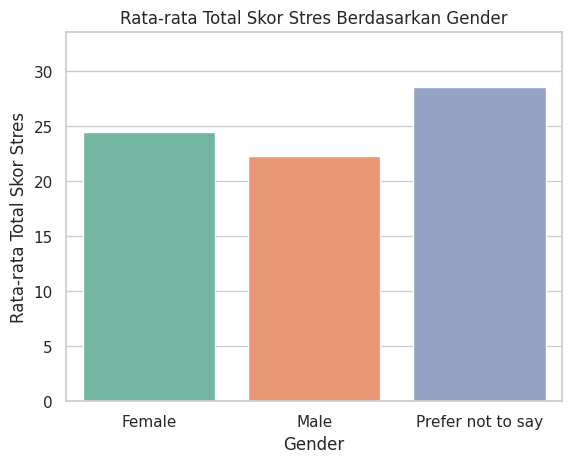

In [15]:
# Tentukan kolom-kolom stres
stress_cols = [col for col in df_cleaned.columns if 'stress_q' in col]

# Hitung total skor stres per baris tanpa menambah kolom baru
total_stress_per_row = df_cleaned[stress_cols].sum(axis=1)

# Hitung rata-rata total stres berdasarkan gender
mean_stress_by_gender = df_cleaned.assign(total_stress_score=total_stress_per_row).groupby('gender')['total_stress_score'].mean().reset_index()

# Visualisasi dengan barplot
sns.barplot(data=mean_stress_by_gender, x='gender', y='total_stress_score', palette='Set2')
plt.title("Rata-rata Total Skor Stres Berdasarkan Gender")
plt.xlabel("Gender")
plt.ylabel("Rata-rata Total Skor Stres")
plt.ylim(0, mean_stress_by_gender['total_stress_score'].max() + 5)
plt.show()


**Insight**

Berdasarkan visualisasi, terlihat perbedaan rata-rata skor stres antar gender: kelompok "Prefer not to say" memiliki rata-rata tertinggi (sekitar 29), diikuti perempuan (sekitar 24.5), dan laki-laki dengan rata-rata terendah (sekitar 22).

Kesimpulan: Terdapat perbedaan tingkat stres berdasarkan gender, dengan kelompok yang tidak mengungkapkan gender mengalami stres tertinggi, sementara laki-laki cenderung mengalami tingkat stres yang lebih rendah dibandingkan perempuan.

# Data Splitting

In [16]:
# Memisahkan fitur (X) dan label target (y) untuk masing-masing kategori: depresi, kecemasan, dan stres
X = df_cleaned.drop(columns=['depression_label', 'anxiety_label', 'stress_label'])
y_depression = df_cleaned['depression_label']
y_anxiety = df_cleaned['anxiety_label']
y_stress = df_cleaned['stress_label']

In [17]:
y_depression

,depression_label
0,Moderate Depression
1,Mild Depression
2,Moderately Severe Depression
3,Mild Depression
4,Mild Depression
...,...
1972,Moderate Depression
1973,Mild Depression
1974,Severe Depression
1975,Moderate Depression


In [18]:
# Split data menjadi 80% data train dan 20% data test untuk 3 label
X_train, X_test, y_dep_train, y_dep_test, y_anx_train, y_anx_test, y_str_train, y_str_test = train_test_split(
    X, y_depression, y_anxiety, y_stress, test_size=0.2, random_state=42
)

# Preprocessing

In [19]:
# Pisahkan fitur kategori dan numerikal
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print("\nCategorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


Categorical Features: ['age', 'gender', 'academic_year', 'cgpa', 'got_scholarship']
Numerical Features: ['anxiety_q1', 'anxiety_q2', 'anxiety_q3', 'anxiety_q4', 'anxiety_q5', 'anxiety_q6', 'anxiety_q7', 'stress_q1', 'stress_q2', 'stress_q3', 'stress_q4', 'stress_q5', 'stress_q6', 'stress_q7', 'stress_q8', 'stress_q9', 'stress_q10', 'depression_q1', 'depression_q2', 'depression_q3', 'depression_q4', 'depression_q5', 'depression_q6', 'depression_q7', 'depression_q8', 'depression_q9']


In [20]:
# Standarisasi fitur numerikal
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# One Hot Encoding fitur kategorikal
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Tambahkan sparse_output=False agar hasilnya array biasa
])

# Gabungkan dalam satu pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)


In [21]:
# Fit dan transform pada train set, transform untuk test set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [22]:
# ONE-HOT ENCODE TARGET (karena klasifikasi multikelas)

# Depression label
le_depression = LabelEncoder()
y_dep_train_encoded = le_depression.fit_transform(y_dep_train)
y_dep_test_encoded = le_depression.transform(y_dep_test)
y_dep_train_cat = to_categorical(y_dep_train_encoded, num_classes=6)
y_dep_test_cat = to_categorical(y_dep_test_encoded, num_classes=6)

# Anxiety label
le_anxiety = LabelEncoder()
y_anx_train_encoded = le_anxiety.fit_transform(y_anx_train)
y_anx_test_encoded = le_anxiety.transform(y_anx_test)
y_anx_train_cat = to_categorical(y_anx_train_encoded, num_classes=4)
y_anx_test_cat = to_categorical(y_anx_test_encoded, num_classes=4)

# Stress lebel
le_stress = LabelEncoder()
y_str_train_encoded = le_stress.fit_transform(y_str_train)
y_str_test_encoded = le_stress.transform(y_str_test)
y_str_train_cat = to_categorical(y_str_train_encoded, num_classes=3)
y_str_test_cat = to_categorical(y_str_test_encoded, num_classes=3)

In [23]:
# Simpan parameter standarisasi
scaler = preprocessor.named_transformers_['num'].named_steps['scaler']
means = scaler.mean_.tolist()
stds = scaler.scale_.tolist()

with open("scaler_params.json", "w") as f:
    json.dump({"mean": means, "std": stds}, f)

In [24]:
# Simpan detail preprocessing
cat_features = preprocessor.transformers_[1][2]
categories = preprocessor.transformers_[1][1].named_steps['onehot'].categories_
num_features = preprocessor.transformers_[0][2]
means = preprocessor.transformers_[0][1].named_steps['scaler'].mean_
stds = preprocessor.transformers_[0][1].named_steps['scaler'].scale_

# Save to a file
with open('preprocessing_details.json', 'w') as f:
    json.dump({
        'categorical_features': cat_features,
        'categories': [c.tolist() for c in categories],
        'numerical_features': num_features,
        'means': means.tolist(),
        'stds': stds.tolist(),
    }, f, indent=2)

In [25]:
# Print the mapping for each label encoder
print("Depression Label Mapping:")
for i, label in enumerate(le_depression.classes_):
    print(f"{label}: {i}")

print("\nAnxiety Label Mapping:")
for i, label in enumerate(le_anxiety.classes_):
    print(f"{label}: {i}")

print("\nStress Label Mapping:")
for i, label in enumerate(le_stress.classes_):
    print(f"{label}: {i}")


Depression Label Mapping:
Mild Depression: 0
Minimal Depression: 1
Moderate Depression: 2
Moderately Severe Depression: 3
No Depression: 4
Severe Depression: 5

Anxiety Label Mapping:
Mild Anxiety: 0
Minimal Anxiety: 1
Moderate Anxiety: 2
Severe Anxiety: 3

Stress Label Mapping:
High Perceived Stress: 0
Low Stress: 1
Moderate Stress: 2


In [26]:
# Print the mapping for categorical features
print("\nCategorical Feature Mappings:")
for feature in categorical_features:
    print(f"\nFeature: {feature}")
    for i, category in enumerate(preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[categorical_features.index(feature)]):
        print(f"{category}: {i}")



Categorical Feature Mappings:

Feature: age
18-22: 0
23-26: 1
27-30: 2
Above 30: 3
Below 18: 4

Feature: gender
Female: 0
Male: 1
Prefer not to say: 2

Feature: academic_year
First Year or Equivalent: 0
Fourth Year or Equivalent: 1
Other: 2
Second Year or Equivalent: 3
Third Year or Equivalent: 4

Feature: cgpa
2.50 - 2.99: 0
3.00 - 3.39: 1
3.40 - 3.79: 2
3.80 - 4.00: 3
Below 2.50: 4
Other: 5

Feature: got_scholarship
No: 0
Yes: 1


In [27]:
print(y_dep_train_cat)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]]


# Modelling

In [28]:
# bangun model
input_layer = Input(shape=(X_train_processed.shape[1],))

x = Dense(128, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)

# Output untuk masing-masing label
output_depression = Dense(6, activation='softmax', name='depression')(x)
output_anxiety = Dense(4, activation='softmax', name='anxiety')(x)
output_stress = Dense(3, activation='softmax', name='stress')(x)

# Model
model = Model(inputs=input_layer, outputs=[output_depression, output_anxiety, output_stress])


In [29]:
# Compile model
model.compile(
    optimizer='adam',
    loss={
        'depression': 'categorical_crossentropy',
        'anxiety': 'categorical_crossentropy',
        'stress': 'categorical_crossentropy'
    },
    metrics={
        'depression': 'accuracy',
        'anxiety': 'accuracy',
        'stress': 'accuracy'
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      6,144 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depression (Dense)  │ (None, 6)         │        390 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 4)         │        260 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stress (Dense)      │ (None, 3)         │        195 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,245 (59.55 KB)

 Trainable params: 15,245 (59.55 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train model
history = model.fit(
    X_train_processed,
    {
        'depression': y_dep_train_cat,
        'anxiety': y_anx_train_cat,
        'stress': y_str_train_cat
    },
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - anxiety_accuracy: 0.4460 - anxiety_loss: 1.1705 - depression_accuracy: 0.3535 - depression_loss: 1.6053 - loss: 3.6860 - stress_accuracy: 0.5545 - stress_loss: 0.9096 - val_anxiety_accuracy: 0.7089 - val_anxiety_loss: 0.7196 - val_depression_accuracy: 0.5348 - val_depression_loss: 1.1001 - val_loss: 2.2395 - val_stress_accuracy: 0.8639 - val_stress_loss: 0.4182
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - anxiety_accuracy: 0.7267 - anxiety_loss: 0.6397 - depression_accuracy: 0.6375 - depression_loss: 0.9442 - loss: 1.9210 - stress_accuracy: 0.9007 - stress_loss: 0.3368 - val_anxiety_accuracy: 0.8101 - val_anxiety_loss: 0.5359 - val_depression_accuracy: 0.6741 - val_depression_loss: 0.8607 - val_loss: 1.6936 - val_stress_accuracy: 0.8861 - val_stress_loss: 0.2958
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - anxiety_accuracy: 0.8286 - anxiety_loss: 0.4844 - depression_accuracy: 0.7436 - depression_loss: 0.7127 - loss: 1

In [31]:
# Evaluasi model
results = model.evaluate(X_test_processed, {
    'depression': y_dep_test_cat,
    'anxiety': y_anx_test_cat,
    'stress': y_str_test_cat
})

print(f"\nTotal Loss: {results[0]:.4f}")
print(f"Loss Depression: {results[1]:.4f}, Accuracy Depression: {results[4]:.4f}")
print(f"Loss Anxiety: {results[2]:.4f}, Accuracy Anxiety: {results[5]:.4f}")
print(f"Loss Stress: {results[3]:.4f}, Accuracy Stress: {results[6]:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - anxiety_accuracy: 0.9794 - anxiety_loss: 0.0550 - depression_accuracy: 0.9466 - depression_loss: 0.1282 - loss: 0.2319 - stress_accuracy: 0.9872 - stress_loss: 0.0492 

Total Loss: 0.2615
Loss Depression: 0.1376, Accuracy Depression: 0.9797
Loss Anxiety: 0.0610, Accuracy Anxiety: 0.9418
Loss Stress: 0.0659, Accuracy Stress: 0.9797


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


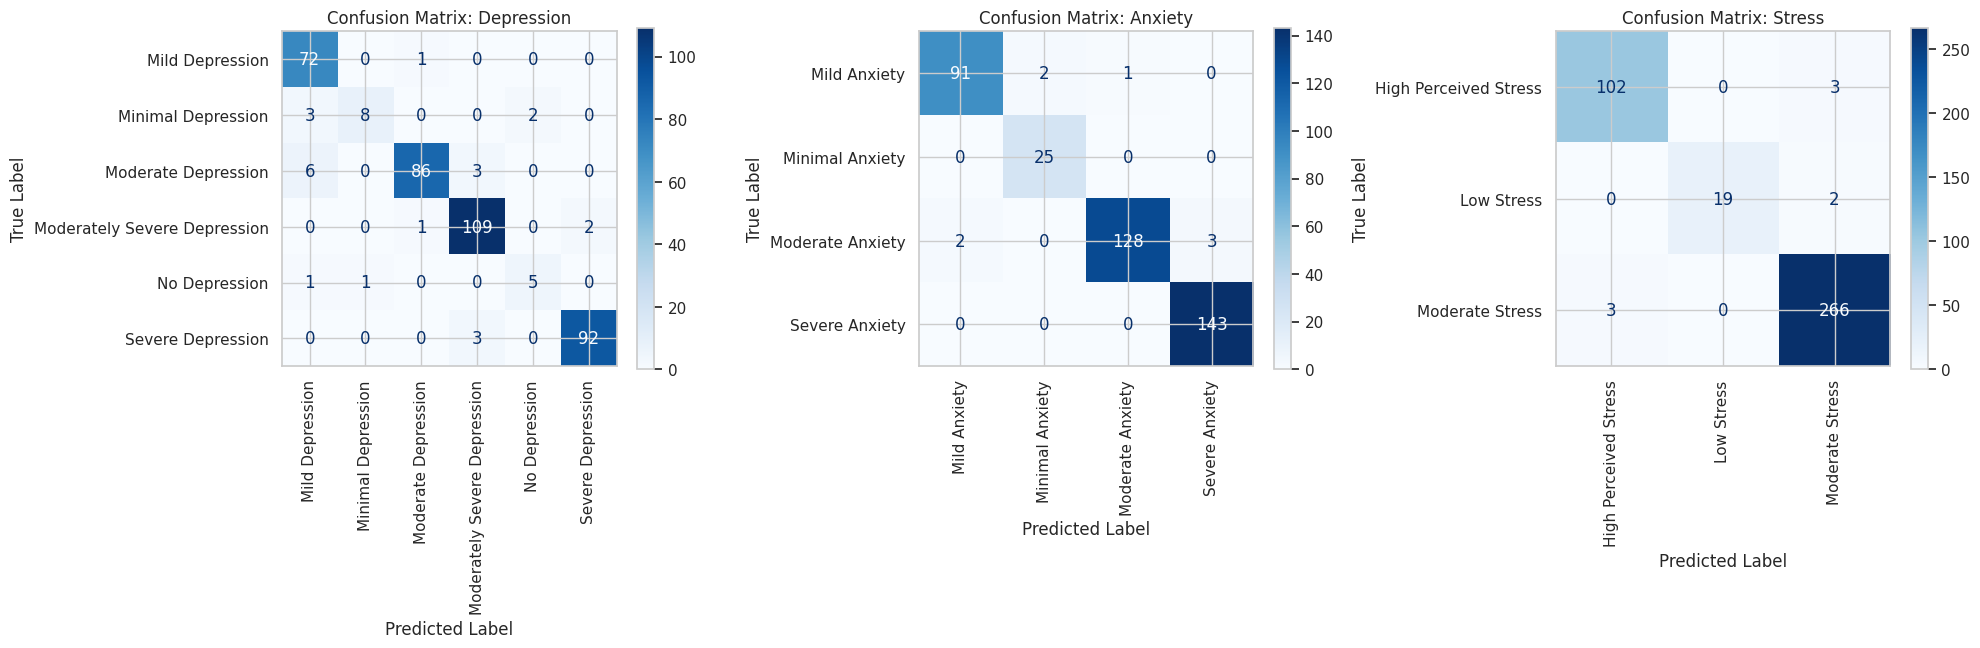

In [32]:
y_pred = model.predict(X_test_processed)
y_pred_depression = le_depression.inverse_transform(np.argmax(y_pred[0], axis=1))
y_pred_anxiety = le_anxiety.inverse_transform(np.argmax(y_pred[1], axis=1))
y_pred_stress = le_stress.inverse_transform(np.argmax(y_pred[2], axis=1))

# Confusion matrix for each label
cm_depression = confusion_matrix(y_dep_test, y_pred_depression, labels=le_depression.classes_)
cm_anxiety = confusion_matrix(y_anx_test, y_pred_anxiety, labels=le_anxiety.classes_)
cm_stress = confusion_matrix(y_str_test, y_pred_stress, labels=le_stress.classes_)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Depression Confusion Matrix
cmp_depression = ConfusionMatrixDisplay(confusion_matrix=cm_depression, display_labels=le_depression.classes_)
cmp_depression.plot(ax=axs[0], cmap=plt.cm.Blues)
axs[0].set_title('Confusion Matrix: Depression')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')
axs[0].tick_params(axis='x', rotation=90)
axs[0].tick_params(axis='y', rotation=0)


# Anxiety Confusion Matrix
cmp_anxiety = ConfusionMatrixDisplay(confusion_matrix=cm_anxiety, display_labels=le_anxiety.classes_)
cmp_anxiety.plot(ax=axs[1], cmap=plt.cm.Blues)
axs[1].set_title('Confusion Matrix: Anxiety')
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')
axs[1].tick_params(axis='x', rotation=90)
axs[1].tick_params(axis='y', rotation=0)

# Stress Confusion Matrix
cmp_stress = ConfusionMatrixDisplay(confusion_matrix=cm_stress, display_labels=le_stress.classes_)
cmp_stress.plot(ax=axs[2], cmap=plt.cm.Blues)
axs[2].set_title('Confusion Matrix: Stress')
axs[2].set_xlabel('Predicted Label')
axs[2].set_ylabel('True Label')
axs[2].tick_params(axis='x', rotation=90)
axs[2].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

In [33]:
# Classification Report for Depression
print("Classification Report - Depression:")
print(classification_report(y_dep_test, y_pred_depression))

# Classification Report for Anxiety
print("\nClassification Report - Anxiety:")
print(classification_report(y_anx_test, y_pred_anxiety))

# Classification Report for Stress
print("\nClassification Report - Stress:")
print(classification_report(y_str_test, y_pred_stress))

Classification Report - Depression:
                              precision    recall  f1-score   support

             Mild Depression       0.88      0.99      0.93        73
          Minimal Depression       0.89      0.62      0.73        13
         Moderate Depression       0.98      0.91      0.94        95
Moderately Severe Depression       0.95      0.97      0.96       112
               No Depression       0.71      0.71      0.71         7
           Severe Depression       0.98      0.97      0.97        95

                    accuracy                           0.94       395
                   macro avg       0.90      0.86      0.87       395
                weighted avg       0.94      0.94      0.94       395


Classification Report - Anxiety:
                  precision    recall  f1-score   support

    Mild Anxiety       0.98      0.97      0.97        94
 Minimal Anxiety       0.93      1.00      0.96        25
Moderate Anxiety       0.99      0.96      0.98     

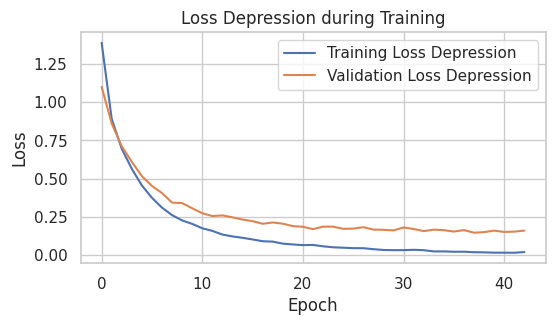

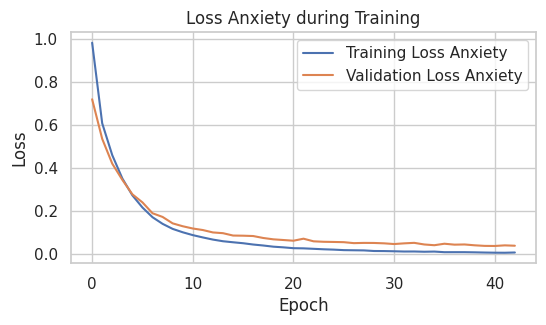

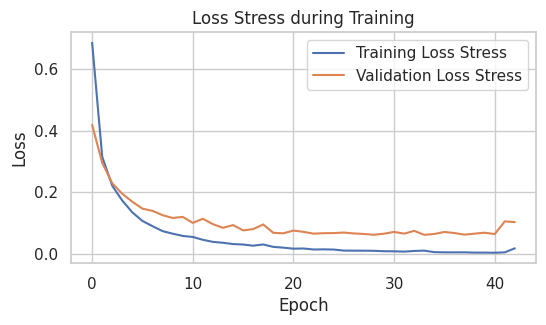

In [34]:
# Depression loss
plt.figure(figsize=(6, 3))
plt.plot(history.history['depression_loss'], label='Training Loss Depression')
plt.plot(history.history['val_depression_loss'], label='Validation Loss Depression')
plt.title('Loss Depression during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Anxiety loss
plt.figure(figsize=(6, 3))
plt.plot(history.history['anxiety_loss'], label='Training Loss Anxiety')
plt.plot(history.history['val_anxiety_loss'], label='Validation Loss Anxiety')
plt.title('Loss Anxiety during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Stress loss
plt.figure(figsize=(6, 3))
plt.plot(history.history['stress_loss'], label='Training Loss Stress')
plt.plot(history.history['val_stress_loss'], label='Validation Loss Stress')
plt.title('Loss Stress during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [35]:
# Buat data baru
new_data = {
    'age': ['18-22', '23-26', '18-22'],
    'gender': ['Male', 'Female', 'Female'],
    'academic_year': ['Third Year or Equivalent', 'Fourth Year or Equivalent', 'First Year or Equivalent'],
    'cgpa': ['3.00 - 3.39', '3.40 - 3.79', '3.40 - 3.79'],
    'got_scholarship': ['No', 'Yes', 'No'],
    'anxiety_q1': [3, 1, 0],
    'anxiety_q2': [3, 1, 2],
    'anxiety_q3': [2, 1, 0],
    'anxiety_q4': [3, 1, 0],
    'anxiety_q5': [3, 1, 1],
    'anxiety_q6': [2, 1, 0],
    'anxiety_q7': [3, 1, 0],
    'stress_q1': [4, 1, 1],
    'stress_q2': [4, 2, 2],
    'stress_q3': [4, 2, 1],
    'stress_q4': [3, 1, 1],
    'stress_q5': [1, 3, 4],
    'stress_q6': [2, 3, 2],
    'stress_q7': [1, 3, 4],
    'stress_q8': [2, 3, 3],
    'stress_q9': [4, 1, 1],
    'stress_q10': [4, 1, 1],
    'depression_q1': [3, 1, 2],
    'depression_q2': [3, 1, 0],
    'depression_q3': [3, 1, 0],
    'depression_q4': [3, 1, 0],
    'depression_q5': [2, 1, 0],
    'depression_q6': [3, 1, 1],
    'depression_q7': [3, 1, 0],
    'depression_q8': [2, 1, 0],
    'depression_q9': [3, 1, 0]
}
new_data_df = pd.DataFrame(new_data)

In [36]:
# Kelompokkan menggunakan data baru ke kategorikal dan numerikal
categorical_features = new_data_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = new_data_df.select_dtypes(include=np.number).columns.tolist()

# Convert types
for col in categorical_features:
    new_data_df[col] = new_data_df[col].astype(str)
for col in numerical_features:
    new_data_df[col] = pd.to_numeric(new_data_df[col], errors='coerce')

# Transform
new_data_processed = preprocessor.transform(new_data_df)

In [37]:
target_cols = ['depression', 'anxiety', 'stress']
label_encoders = {
    'depression': le_depression,
    'anxiety': le_anxiety,
    'stress': le_stress
}

# Prediksi
predictions = model.predict(new_data_processed)

# Tampilkan hasil
for i in range(len(new_data_df)):
    print(f"Sample {i+1}: Predicted Labels = [", end='')
    label_outputs = []

    for j, col in enumerate(target_cols):
        pred_probs = predictions[j][i]
        predicted_class_index = np.argmax(pred_probs)
        predicted_label = label_encoders[col].inverse_transform([predicted_class_index])[0]
        label_outputs.append(f"'{predicted_label}'")

    print(" ".join(label_outputs) + "]")

    for j, col in enumerate(target_cols):
        pred_probs = predictions[j][i]
        classes = label_encoders[col].classes_
        prob_dict = {label: f"{prob:.4f}" for label, prob in zip(classes, pred_probs)}
        print(f"  For label {col}_label:")
        print(f"    Probabilities: {prob_dict}")

    print("----------------------------------------------------")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sample 1: Predicted Labels = ['Severe Depression' 'Severe Anxiety' 'High Perceived Stress']
  For label depression_label:
    Probabilities: {'Mild Depression': '0.0000', 'Minimal Depression': '0.0000', 'Moderate Depression': '0.0000', 'Moderately Severe Depression': '0.0000', 'No Depression': '0.0000', 'Severe Depression': '1.0000'}
  For label anxiety_label:
    Probabilities: {'Mild Anxiety': '0.0000', 'Minimal Anxiety': '0.0000', 'Moderate Anxiety': '0.0000', 'Severe Anxiety': '1.0000'}
  For label stress_label:
    Probabilities: {'High Perceived Stress': '1.0000', 'Low Stress': '0.0000', 'Moderate Stress': '0.0000'}
----------------------------------------------------
Sample 2: Predicted Labels = ['Mild Depression' 'Mild Anxiety' 'Moderate Stress']
  For label depression_label:
    Probabilities: {'Mild Depression': '0.9966', 'Minimal Depression': '0.0001', 'Moderate Depression': '0.0033', 'Moderately Severe Depression': '0.0000', 'No Depress

# Save ke TFJS

In [38]:
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 47), dtype=tf.float32, name='keras_tensor')
Output Type:
  List[TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  140678744901968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140678744902544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140678744904464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140678744902352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140678744905040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140678744907728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140678744906000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140678744905232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140678744902160: TensorSpec(shape=(), dtype=tf

In [39]:
!pip install tensorflowjs

In [40]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model

2025-05-22 17:04:19.805853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747933459.853396    8740 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747933459.866737    8740 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-22 17:04:30.269417: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1747933470.466112    8740 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [41]:
import shutil
from google.colab import files

shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>